In [27]:
import torch

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from scipy import stats
import scikit_posthocs as sp

import numpy as np

from cnn import CNN, ResNet, CNNTransferLearning

Loading data.

In [2]:
baseline = torch.load('best_models/mandioca_baseline.pth', map_location='cpu', weights_only=True)
plantvillage_da = torch.load('best_models/mandioca_plantvillage_domain_adaptation.pth', map_location='cpu', weights_only=True)
plantvillage_ft = torch.load('best_models/mandioca_plantvillage_fine_tuning.pth', map_location='cpu', weights_only=True)
resnet_da = torch.load('best_models/mandioca_resnet_domain_adaptation.pth', map_location='cpu', weights_only=True)
resnet_ft = torch.load('best_models/mandioca_resnet_fine_tuning.pth', map_location='cpu', weights_only=True)

## Learning Curves

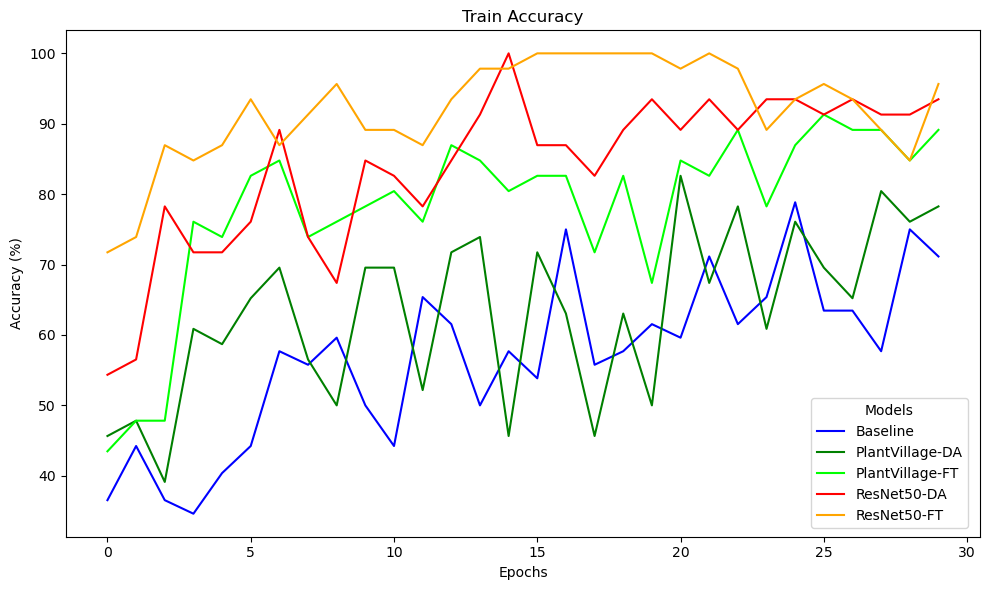

In [3]:
epochs = [i for i in range(30)]

fig = plt.figure(figsize=(10, 6))
plt.plot(epochs, baseline['train_acc'], color='blue')
plt.plot(epochs, plantvillage_da['train_acc'], color='green')
plt.plot(epochs, plantvillage_ft['train_acc'], color='lime')
plt.plot(epochs, resnet_da['train_acc'], color='red')
plt.plot(epochs, resnet_ft['train_acc'], color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train Accuracy')

names = ['Baseline', 'PlantVillage-DA', 'PlantVillage-FT', 'ResNet50-DA', 'ResNet50-FT']
colors = ['blue', 'green', 'lime', 'red', 'orange']

legend_elements = []
for color, name in zip(colors, names):
    legend_elements.append(Line2D([0], [0], label=name, linestyle='-', color=color))

fig.legend(
    handles=legend_elements,
    loc='lower right', 
    ncol=1,
    frameon=True,
    title='Models',
    bbox_to_anchor=(.98, 0.1)
)

plt.tight_layout()
plt.show()

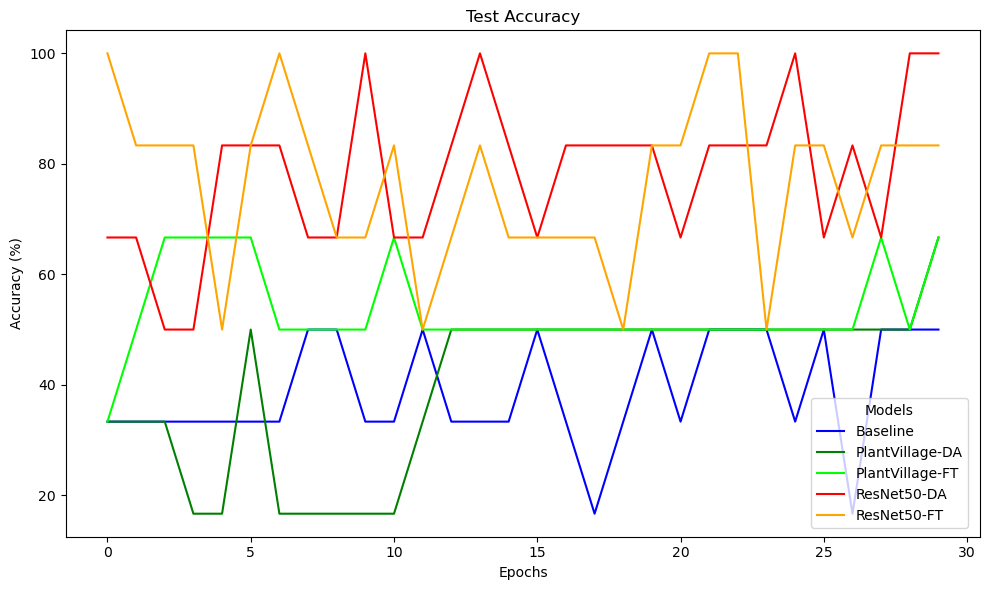

In [4]:
epochs = [i for i in range(30)]

fig = plt.figure(figsize=(10, 6))
plt.plot(epochs, baseline['test_acc'], color='blue')
plt.plot(epochs, plantvillage_da['test_acc'], color='green')
plt.plot(epochs, plantvillage_ft['test_acc'], color='lime')
plt.plot(epochs, resnet_da['test_acc'], color='red')
plt.plot(epochs, resnet_ft['test_acc'], color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')

names = ['Baseline', 'PlantVillage-DA', 'PlantVillage-FT', 'ResNet50-DA', 'ResNet50-FT']
colors = ['blue', 'green', 'lime', 'red', 'orange']

legend_elements = []
for color, name in zip(colors, names):
    legend_elements.append(Line2D([0], [0], label=name, linestyle='-', color=color))

fig.legend(
    handles=legend_elements,
    loc='lower right', 
    ncol=1,
    frameon=True,
    title='Models',
    bbox_to_anchor=(.98, 0.1)
)

plt.tight_layout()
plt.show()

## KFold

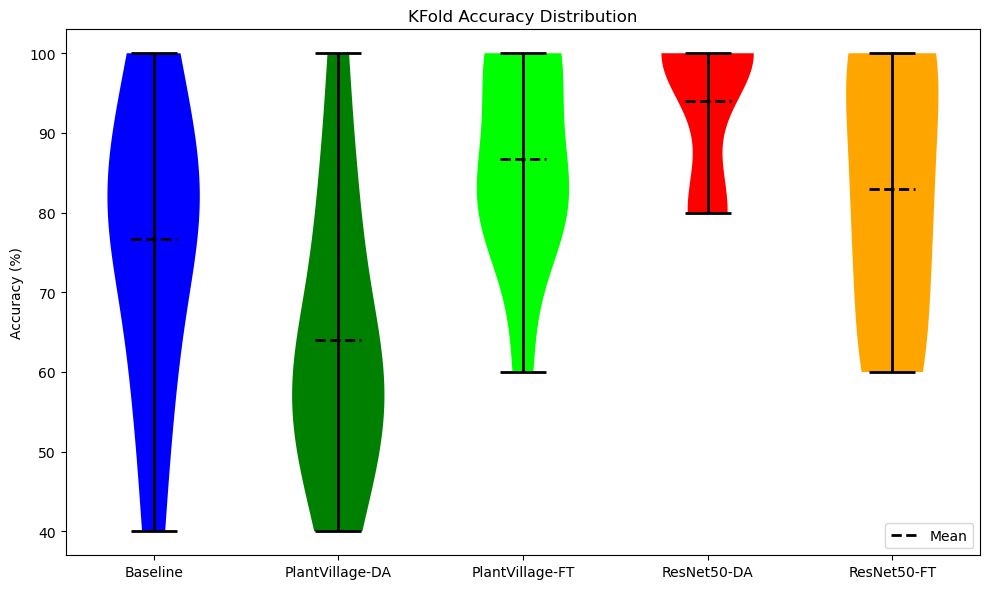

In [5]:
folds = [i for i in range(10)]
models = {
    'Baseline': baseline['kfold_acc'],
    'PlantVillage-DA': plantvillage_da['kfold_acc'],
    'PlantVillage-FT': plantvillage_ft['kfold_acc'],
    'ResNet50-DA': resnet_da['kfold_acc'],
    'ResNet50-FT': resnet_ft['kfold_acc']
}

colors = ['blue', 'green', 'lime', 'red', 'orange']

fig, ax = plt.subplots(figsize=(10, 6))

violin_parts = ax.violinplot(models.values(), showmeans=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(1.)

for partname in ('cmeans',):
    vp = violin_parts[partname]
    vp.set_color('black')     
    vp.set_linestyle('--') 
    vp.set_linewidth(2)

for partname in ('cbars',):
    vp = violin_parts[partname]
    vp.set_color('black')

for partname in ('cmins', 'cmaxes', 'cbars'):
    vp = violin_parts[partname]
    vp.set_color('black')
    vp.set_linewidth(2)

ax.set_xticks(range(1, len(models)+1))
ax.set_xticklabels(models.keys())
ax.set_ylabel('Accuracy (%)')
ax.set_title('KFold Accuracy Distribution')

legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Mean'),
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True)

plt.tight_layout()
plt.show()

## Hypothesis Test

Kruscal test.

In [25]:
model_dict = {
    'baseline': baseline['kfold_acc'],
    'plantvillage_da': plantvillage_da['kfold_acc'],
    'plantvillage_ft': plantvillage_ft['kfold_acc'], 
    'resnet_da': resnet_da['kfold_acc'],
    'resnet_ft': resnet_ft['kfold_acc'], 
}

stat, pvalue = stats.kruskal(*list(model_dict.values()))
print(f'p-value: {pvalue}')

p-value: 0.005672343524593176


Dunn post-hoc.

In [26]:
pvalue_matrix = sp.posthoc_dunn(list(model_dict.values()))
pvalue_matrix

,1,2,3,4,5
1,1.000000,0.120773,0.248620,0.041661,0.478860
2,0.120773,1.000000,0.006825,0.000333,0.023841
3,0.248620,0.006825,1.000000,0.377138,0.655908
4,0.041661,0.000333,0.377138,1.000000,0.183930
5,0.478860,0.023841,0.655908,0.183930,1.000000


## Metrics